## Youtube comments analysis

In this notebook, we have a 240MB compressed dataset of user comments for youtube videos related to animals or pets. We will attempt to identify cat or dog owners based on these comments, find out the topics important to them, and then identify video creators with the most viewers that are cat or dog owners. Steps are as follows:

- Step 1: Identify Cat And Dog Owners: Find the users who are cat and/or dog owners.
- Step 2: Build classifiers for the cat and dog owners and measure the performance of the classifiers.
- Step 3: Apply the cat/dog classifiers to all the users in the dataset. Estimate the fraction of all users who are cat/dog owners.
- Step 4: Extract insights about cat and dog owners and find topics important to them.
- Step 5: Find creators with the most or highest statistically significant percentages of cat and/or dog owners.

**Spark version: 2.4.5**

In [0]:
# download data
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1o3DsS3jN_t2Mw3TsV0i7ySRmh9kyYi1a', dest_path='./../../dbfs/FileStore/youtube_comments/animal_comments.gz')

In [0]:
%sh
gunzip -k /dbfs/FileStore/youtube_comments/animal_comments.gz
ls ../../dbfs/FileStore/youtube_comments/

gzip: /dbfs/FileStore/youtube_comments/animal_comments already exists;	not overwritten
animal_comments
animal_comments.gz

### Step 0. Exploratory Data Analysis

In [0]:
df = spark.read.csv("/FileStore/youtube_comments/animal_comments",inferSchema=True,header=True)
df.show(10)

+--------------------+------+-------------------------------------+
 creator_name|userid| comment|
+--------------------+------+-------------------------------------+
 Doug The Pug| 87.0| I shared this to ...|
 Doug The Pug| 87.0| Super cute 😀🐕🐶|
 bulletproof| 530.0| stop saying get e...|
 Meu Zoológico| 670.0| Tenho uma jiboia ...|
 ojatro|1031.0| I wanna see what ...|
 Tingle Triggers|1212.0| Well shit now Im ...|
Hope For Paws - O...|1806.0| when I saw the en...|
Hope For Paws - O...|2036.0| Holy crap. That i...|
 Life Story|2637.0|武器はクエストで貰えるんじゃないん...|
 Brian Barczyk|2698.0| Call the teddy Larry|
+--------------------+------+-------------------------------------+
only showing top 10 rows

#### How many comments are there?

In [0]:
df.count() 

Out[4]: 5820035

In [0]:
df_clean = df.na.drop(subset=["comment"])
df_clean.count()

Out[5]: 5818984

In [0]:
df_clean.show(10)

+--------------------+------+-------------------------------------+
 creator_name|userid| comment|
+--------------------+------+-------------------------------------+
 Doug The Pug| 87.0| I shared this to ...|
 Doug The Pug| 87.0| Super cute 😀🐕🐶|
 bulletproof| 530.0| stop saying get e...|
 Meu Zoológico| 670.0| Tenho uma jiboia ...|
 ojatro|1031.0| I wanna see what ...|
 Tingle Triggers|1212.0| Well shit now Im ...|
Hope For Paws - O...|1806.0| when I saw the en...|
Hope For Paws - O...|2036.0| Holy crap. That i...|
 Life Story|2637.0|武器はクエストで貰えるんじゃないん...|
 Brian Barczyk|2698.0| Call the teddy Larry|
+--------------------+------+-------------------------------------+
only showing top 10 rows

#### How many creators and users are there?

In [0]:
creators_count = df_clean.select('creator_name').distinct().count()
creators_count

Out[7]: 3859

In [0]:
users_count = df_clean.select('userid').distinct().count()
users_count

Out[8]: 2536892

#### How may comments did each creator get?

In [0]:
comments_per_creator = df_clean.groupBy('creator_name').count().orderBy('count', ascending=False)
comments_per_creator = comments_per_creator.withColumnRenamed('count', 'comments_count')
comments_per_creator.show(5)

+--------------------+--------------+
 creator_name|comments_count|
+--------------------+--------------+
 Brave Wilderness| 1048668|
 Brian Barczyk| 386306|
 The Dodo| 325058|
 Taylor Nicole Dean| 235635|
Hope For Paws - O...| 127716|
+--------------------+--------------+
only showing top 5 rows

In [0]:
comments_max = comments_per_creator.groupBy().max('comments_count').collect()[0]['max(comments_count)']
comments_min = comments_per_creator.groupBy().min('comments_count').collect()[0]['min(comments_count)']
comments_avg = comments_per_creator.groupBy().avg('comments_count').collect()[0]['avg(comments_count)']

print('As per creator:')
print('Maximun comments count =', comments_max)
print('Minimum comments count =', comments_min)
print('Average comments count =', int(comments_avg))

As per creator:
Maximun comments count = 1048668
Minimum comments count = 1
Average comments count = 1507

#### How many users have left comments for each creator?

In [0]:
users_per_creator = df_clean.select('creator_name', 'userid').distinct() \
                            .groupBy('creator_name').count().orderBy('count', ascending=False)
users_per_creator = users_per_creator.withColumnRenamed('count', 'users_count')
users_per_creator.show(5)

+--------------------+-----------+
 creator_name|users_count|
+--------------------+-----------+
 Brave Wilderness| 635800|
 The Dodo| 166788|
 Brian Barczyk| 136338|
 Taylor Nicole Dean| 135454|
Hope For Paws - O...| 91761|
+--------------------+-----------+
only showing top 5 rows

In [0]:
users_max = users_per_creator.groupBy().max('users_count').collect()[0]['max(users_count)']
users_min = users_per_creator.groupBy().min('users_count').collect()[0]['min(users_count)']
users_avg = users_per_creator.groupBy().avg('users_count').collect()[0]['avg(users_count)']

print('As per creator:')
print('Maximun users count =', users_max)
print('Minimum users count =', users_min)
print('Average users count =', int(users_avg))

As per creator:
Maximun users count = 635800
Minimum users count = 1
Average users count = 826

### Step 1: Identify Cat And Dog Owners

In [0]:
# find user with preference of dog and cat
from pyspark.sql.functions import when
from pyspark.sql.functions import col

# you can user your ways to extract the label

df_clean = df_clean.withColumn("label", \
                           (when(col("comment").like("%my dog%"), 1) \
                           .when(col("comment").like("%I have a dog%"), 1) \
                           .when(col("comment").like("%my cat%"), 1) \
                           .when(col("comment").like("%I have a cat%"), 1) \
                           .when(col("comment").like("%my puppy%"), 1) \
                           .when(col("comment").like("%my pup%"), 1) \
                           .when(col("comment").like("%my kitty%"), 1) \
                           .when(col("comment").like("%my pussy%"), 1) \
                           .otherwise(0)))

In [0]:
label0_count = df_clean.filter(col('label')==0).count()
label1_count = df_clean.filter(col('label')==1).count()
print('There are {} rows with label 0 and {} rows with label 1.'.format(label0_count, label1_count))
df_clean.show(10)

There are 5778759 rows with label 0 and 40225 rows with label 1.
+--------------------+------+-------------------------------------+-----+
 creator_name|userid| comment|label|
+--------------------+------+-------------------------------------+-----+
 Doug The Pug| 87.0| I shared this to ...| 0|
 Doug The Pug| 87.0| Super cute 😀🐕🐶| 0|
 bulletproof| 530.0| stop saying get e...| 0|
 Meu Zoológico| 670.0| Tenho uma jiboia ...| 0|
 ojatro|1031.0| I wanna see what ...| 0|
 Tingle Triggers|1212.0| Well shit now Im ...| 0|
Hope For Paws - O...|1806.0| when I saw the en...| 0|
Hope For Paws - O...|2036.0| Holy crap. That i...| 0|
 Life Story|2637.0|武器はクエストで貰えるんじゃないん...| 0|
 Brian Barczyk|2698.0| Call the teddy Larry| 0|
+--------------------+------+-------------------------------------+-----+
only showing top 10 rows

### Step 2: Build classifiers
#### Data preprocessing

In [0]:
from pyspark.ml.feature import RegexTokenizer, Word2Vec
from pyspark.ml import Pipeline

# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="comment", outputCol="words", pattern="\\W") # a-z, A-Z, 0-9
word2Vec = Word2Vec(inputCol="words", outputCol="features")

pipeline = Pipeline(stages=[regexTokenizer, word2Vec])

# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(df_clean)
dataset = pipelineFit.transform(df_clean)

In [0]:
dataset.show(10)

+--------------------+------+-------------------------------------+-----+--------------------+--------------------+
 creator_name|userid| comment|label| words| features|
+--------------------+------+-------------------------------------+-----+--------------------+--------------------+
 Doug The Pug| 87.0| I shared this to ...| 0|[i, shared, this,...|[0.00126117137684...|
 Doug The Pug| 87.0| Super cute 😀🐕🐶| 0| [super, cute]|[-0.3670367747545...|
 bulletproof| 530.0| stop saying get e...| 0|[stop, saying, ge...|[0.05950683059001...|
 Meu Zoológico| 670.0| Tenho uma jiboia ...| 0|[tenho, uma, jibo...|[0.24376948426167...|
 ojatro|1031.0| I wanna see what ...| 0|[i, wanna, see, w...|[0.02837712715633...|
 Tingle Triggers|1212.0| Well shit now Im ...| 0|[well, shit, now,...|[-0.0347539581358...|
Hope For Paws - O...|1806.0| when I saw the en...| 0|[when, i, saw, th...|[0.04614003824685...|
Hope For Paws - O...|2036.0| Holy crap. That i...| 0|[holy, crap, that...|[-0.0128582379279...|
 Life Story|2637.0|武器はクエストで貰えるんじゃないん...| 0| []| (100,[],[])|
 Brian Barczyk|2698.0| Call the teddy Larry| 0|[call, the, teddy...|[0.17046481161378...|
+--------------------+------+-------------------------------------+-----+--------------------+--------------------+
only showing top 10 rows

In [0]:
# balance data so that label0 : label1 = 1 : 1
label1_data = dataset.filter(col('label')==1)
label0_data = dataset.filter(col('label')==0).sample(0.1, seed=100).limit(label1_count)

In [0]:
split = [0.8, 0.2]
label0_train, label0_test = label0_data.randomSplit(split, seed=100)
label1_train, label1_test = label1_data.randomSplit(split, seed=100)

print('Number of label 0 in training set: {}'.format(label0_train.count()))
print('Number of label 1 in training set: {}'.format(label1_train.count()))
print('Number of label 0 in testing set: {}'.format(label0_test.count()))
print('Number of label 1 in testing set: {}'.format(label1_test.count()))

Number of label 0 in training set: 32161
Number of label 1 in training set: 32237
Number of label 0 in testing set: 8064
Number of label 1 in testing set: 7988

In [0]:
trainingData = label0_train.union(label1_train)
testData=label0_test.union(label1_test)

In [0]:
print("Dataset Count: " + str(dataset.count()))
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Dataset Count: 5818984
Training Dataset Count: 64398
Test Dataset Count: 16052

#### 2.1 LogisticRegression

In [0]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol='label', featuresCol='features', maxIter=10)
lrFit = lr.fit(trainingData)

In [0]:
lrPredictions = lrFit.transform(testData)
lrPredictions.show(10)

+------------+--------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
creator_name| userid| comment|label| words| features| rawPrediction| probability|prediction|
+------------+--------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
 null| 57382.0|Mashallah janwer ...| 0|[mashallah, janwe...|[0.24714324209425...|[14.9217113151699...|[0.99999966918669...| 0.0|
 null| 74711.0|Mash Allah boht k...| 0|[mash, allah, boh...|[0.44828125834465...|[14.4461785435246...|[0.99999946776412...| 0.0|
 null| 97163.0|Ive watched sever...| 0|[ive, watched, se...|[0.08922217036597...|[2.46674446816806...|[0.92177735052138...| 0.0|
 null|119417.0|Plesse let your a...| 0|[plesse, let, you...|[0.00986058358103...|[5.64221513763756...|[0.99646751565787...| 0.0|
 null|180336.0|I really enjoyed ...| 0|[i, really, enjoy...|[0.03238957575724...|[0.91793461395782...|[0.71462108221285...| 0.0|
 null|213177.0| you sound like poop| 0|[you, sound, like...|[0.02869419095804...|[2.32708596562164...|[0.91109558131717...| 0.0|
 null|241742.0|I HAVE FOUND ANOT...| 0|[i, have, found, ...|[0.06181205101311...|[1.80872797008264...|[0.85920806765978...| 0.0|
 null|286148.0|or maybe i should...| 0|[or, maybe, i, sh...|[0.05039609862225...|[0.69761925100292...|[0.66765971827727...| 0.0|
 null|287637.0|Its all in the genes| 0|[its, all, in, th...|[0.10658140759915...|[2.29673942033706...|[0.90860663893798...| 0.0|
 null|352160.0|You are looking s...| 0|[you, are, lookin...|[-0.1556396560950...|[3.27470281686512...|[0.96355069872237...| 0.0|
+------------+--------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
only showing top 10 rows

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction')
metrics = evaluator.getMetricName()

In [0]:
print(metrics, ':', evaluator.evaluate(lrPredictions))
print('regParam: ', lrFit._java_obj.parent().getRegParam())
print('elasticNetParam: ', lrFit._java_obj.parent().getElasticNetParam())
print('maxIter: ', lrFit._java_obj.parent().getMaxIter())

areaUnderROC : 0.9560301048050263
regParam: 0.0
elasticNetParam: 0.0
maxIter: 10

In [0]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid_lr = (ParamGridBuilder().addGrid(lr.regParam, [0.0, 0.5, 1.0])
                                  .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
                                  .addGrid(lr.maxIter, [20, 50, 100])
                                  .build())

cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid_lr, evaluator=evaluator, numFolds=5)

In [0]:
cvFit_lr = cv_lr.fit(trainingData)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
bestModel_lr = cvFit_lr.bestModel

# use the best model to predict
bestPredictions_lr = bestModel_lr.transform(testData)

In [0]:
bestPredictions_lr.show(10)

+------------+--------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
creator_name| userid| comment|label| words| features| rawPrediction| probability|prediction|
+------------+--------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
 null| 57382.0|Mashallah janwer ...| 0|[mashallah, janwe...|[0.24714324209425...|[13.4672845681573...|[0.99999858344966...| 0.0|
 null| 74711.0|Mash Allah boht k...| 0|[mash, allah, boh...|[0.44828125834465...|[12.8164044086167...|[0.99999728415419...| 0.0|
 null| 97163.0|Ive watched sever...| 0|[ive, watched, se...|[0.08922217036597...|[2.21729550553533...|[0.90179193704675...| 0.0|
 null|119417.0|Plesse let your a...| 0|[plesse, let, you...|[0.00986058358103...|[5.06370241329266...|[0.99371760889434...| 0.0|
 null|180336.0|I really enjoyed ...| 0|[i, really, enjoy...|[0.03238957575724...|[0.66595614971376...|[0.66059708295323...| 0.0|
 null|213177.0| you sound like poop| 0|[you, sound, like...|[0.02869419095804...|[2.72520157285542...|[0.93849745411554...| 0.0|
 null|241742.0|I HAVE FOUND ANOT...| 0|[i, have, found, ...|[0.06181205101311...|[1.55737851092522...|[0.82597686448503...| 0.0|
 null|286148.0|or maybe i should...| 0|[or, maybe, i, sh...|[0.05039609862225...|[0.80831535274103...|[0.69175040004822...| 0.0|
 null|287637.0|Its all in the genes| 0|[its, all, in, th...|[0.10658140759915...|[2.63100264348562...|[0.93283040016231...| 0.0|
 null|352160.0|You are looking s...| 0|[you, are, lookin...|[-0.1556396560950...|[2.64773282243671...|[0.93387111667053...| 0.0|
+------------+--------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
only showing top 10 rows

In [0]:
print('For the best logistic regression model:')
print(metrics, ':', evaluator.evaluate(bestPredictions_lr))
print('regParam: ', bestModel_lr._java_obj.parent().getRegParam())
print('elasticNetParam: ', bestModel_lr._java_obj.parent().getElasticNetParam())
print('maxIter: ', bestModel_lr._java_obj.parent().getMaxIter())

For the best logistic regression model:
areaUnderROC : 0.9576143729483123
regParam: 0.0
elasticNetParam: 1.0
maxIter: 100

#### 2.2 RandomForest

In [0]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='label', featuresCol='features')
rfFit = rf.fit(trainingData)

In [0]:
rfPredictions = rfFit.transform(testData)
print(metrics, ':', evaluator.evaluate(rfPredictions))
print('maxDepth: ', rfFit._java_obj.parent().getMaxDepth())
print('maxBins: ', rfFit._java_obj.parent().getMaxBins())
print('numTrees: ', rfFit._java_obj.parent().getNumTrees())

areaUnderROC : 0.9471448150648608
maxDepth: 5
maxBins: 32
numTrees: 20

In [0]:
paramGrid_rf = (ParamGridBuilder().addGrid(rf.maxDepth, [2, 5, 10])
                                  .addGrid(rf.maxBins, [20, 35, 50])
                                  .addGrid(rf.numTrees, [10, 20, 30])
                                  .build())

cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid_rf, evaluator=evaluator, numFolds=5)

In [0]:
cvFit_rf = cv_rf.fit(trainingData)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
bestModel_rf = cvFit_rf.bestModel

# use the best model to predict
bestPredictions_rf = bestModel_rf.transform(testData)

In [0]:
print('For the best random forest model:')
print(metrics, ':', evaluator.evaluate(bestPredictions_rf))
print('maxDepth: ', bestModel_rf._java_obj.parent().getMaxDepth())
print('maxBins: ', bestModel_rf._java_obj.parent().getMaxBins())
print('numTrees: ', bestModel_rf._java_obj.parent().getNumTrees())

For the best random forest model:
areaUnderROC : 0.963431063944621
maxDepth: 10
maxBins: 20
numTrees: 30

#### 2.3 Gradient boosting trees

In [0]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol='label', featuresCol='features')
gbtFit = gbt.fit(trainingData)

In [0]:
gbtPredictions = gbtFit.transform(testData)

In [0]:
print(metrics, ':', evaluator.evaluate(gbtPredictions))
print('maxDepth: ', gbtFit._java_obj.parent().getMaxDepth())
print('maxBins: ', gbtFit._java_obj.parent().getMaxBins())
print('maxIter: ', gbtFit._java_obj.parent().getMaxIter())

areaUnderROC : 0.9580513425768665
maxDepth: 5
maxBins: 32
maxIter: 20

In [0]:
paramGrid_gbt = (ParamGridBuilder().addGrid(rf.maxDepth, [2, 5, 10])
                                  .addGrid(rf.maxBins, [10, 20, 40])
                                  .addGrid(rf.numTrees, [10, 20, 30])
                                  .build())

cv_gbt = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid_gbt, evaluator=evaluator, numFolds=5)

In [0]:
cvFit_gbt = cv_gbt.fit(trainingData)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
bestModel_gbt = cvFit_gbt.bestModel

# use the best model to predict
bestPredictions_gbt = bestModel_gbt.transform(testData)

In [0]:
print('For the best gradient boosted tree model:')
print(metrics, ':', evaluator.evaluate(bestPredictions_gbt))
print('maxDepth: ', bestModel_gbt._java_obj.parent().getMaxDepth())
print('maxBins: ', bestModel_gbt._java_obj.parent().getMaxBins())
print('maxIter: ', bestModel_gbt._java_obj.parent().getMaxIter())

For the best gradient boosted tree model:
areaUnderROC : 0.9580513425768669
maxDepth: 5
maxBins: 32
maxIter: 20

### Step 3: Model application

In [0]:
# for re-attach to the cluster
# from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
# bestModel_lr = LogisticRegression(labelCol='label', featuresCol='features', regParam=0.0, elasticNetParam=1.0, maxIter=100).fit(trainingData)
# bestModel_rf = RandomForestClassifier(labelCol='label', featuresCol='features', maxDepth=10, maxBins=20, numTrees=30).fit(trainingData)
# bestModel_gbt = GBTClassifier(labelCol='label', featuresCol='features', maxDepth=5, maxBins=32, maxIter=20).fit(trainingData)

In [0]:
allPredictions_lr = bestModel_lr.transform(dataset)
allPredictions_rf = bestModel_rf.transform(dataset)
allPredictions_gbt = bestModel_gbt.transform(dataset)

In [0]:
print('The logistic regression model estimates that {:.3f}% of users are cat/dog owners.'.format(allPredictions_lr.filter(col('prediction')==1.0).count() *100 / allPredictions_lr.count()))
print('The random forest model estimates that {:.3f}% of users are cat/dog owners.'.format(allPredictions_rf.filter(col('prediction')==1.0).count() *100 / allPredictions_rf.count()))
print('The gradient boosted tree model estimates that {:.3f}% of users are cat/dog owners.'.format(allPredictions_gbt.filter(col('prediction')==1.0).count() *100 / allPredictions_gbt.count()))

The logistic regression model estimates that 12.071% of users are cat/dog owners.
The random forest model estimates that 13.686% of users are cat/dog owners.
The gradient boosted tree model estimates that 13.934% of users are cat/dog owners.

We can see the gradient boosted trees model identifies slightly more cat/dog owners, while all three models have similar performance. Suppose we are sending advertisements or coupons to these identified owners, it may not hurt to have a little fraction of misidentified users. Therefore, I will use gradient boosted tree model for the following analysis.

### Step 4: Extract insights and topics from cat/dog owners

In [0]:
predicted_not_owners = allPredictions_gbt.filter(col('prediction')==0.0).drop('rawPrediction', 'probability')
predicted_owners = allPredictions_gbt.filter(col('prediction')==1.0).drop('rawPrediction', 'probability')
predicted_owners.show(5)

+--------------------+-------+--------------------+-----+--------------------+--------------------+----------+
 creator_name| userid| comment|label| words| features|prediction|
+--------------------+-------+--------------------+-----+--------------------+--------------------+----------+
 Doug The Pug| 87.0|I shared this to ...| 0|[i, shared, this,...|[0.00126117137684...| 1.0|
Hope For Paws - O...| 2911.0|That mother cat l...| 0|[that, mother, ca...|[-0.0410638787804...| 1.0|
 Talking Kitty Cat| 2911.0|steve: No wet foo...| 0|[steve, no, wet, ...|[0.17674692754041...| 1.0|
 Taylor Nicole Dean|10336.0|I dont understand...| 0|[i, dont, underst...|[0.08113597049520...| 1.0|
 Rachel Fusaro|10765.0|Im not allowed to...| 0|[im, not, allowed...|[0.04574502201285...| 1.0|
+--------------------+-------+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows

**Identify cat/dog owners for which predictions are consistent with initial labels**

In [0]:
predicted_owners = predicted_owners.withColumn('match_label', col('label')==col('prediction'))
predicted_owners.show(5)

+--------------------+-------+--------------------+-----+--------------------+--------------------+----------+-----------+
 creator_name| userid| comment|label| words| features|prediction|match_label|
+--------------------+-------+--------------------+-----+--------------------+--------------------+----------+-----------+
 Doug The Pug| 87.0|I shared this to ...| 0|[i, shared, this,...|[0.00126117137684...| 1.0| false|
Hope For Paws - O...| 2911.0|That mother cat l...| 0|[that, mother, ca...|[-0.0410638787804...| 1.0| false|
 Talking Kitty Cat| 2911.0|steve: No wet foo...| 0|[steve, no, wet, ...|[0.17674692754041...| 1.0| false|
 Taylor Nicole Dean|10336.0|I dont understand...| 0|[i, dont, underst...|[0.08113597049520...| 1.0| false|
 Rachel Fusaro|10765.0|Im not allowed to...| 0|[im, not, allowed...|[0.04574502201285...| 1.0| false|
+--------------------+-------+--------------------+-----+--------------------+--------------------+----------+-----------+
only showing top 5 rows

In [0]:
owners_count = predicted_owners.groupBy('match_label').count()
display(owners_count)  

match_label,count
true,36840
false,774005


In [0]:
# owners for whom prediction is consistent with label
labeled_owners = predicted_owners.filter(col('match_label')==True)

# owners for whom prediction is inconsistent with label
identified_owners = predicted_owners.filter(col('match_label')==False)

#### 4.1 Topics among pre-labeled owners

In [0]:
from pyspark.ml.feature import StopWordsRemover

remover = StopWordsRemover(inputCol='words', outputCol='filtered')
labeled_owners_filtered = remover.transform(labeled_owners)
labeled_owners_filtered.show(5)

+--------------------+--------+--------------------+-----+--------------------+--------------------+----------+-----------+--------------------+
 creator_name| userid| comment|label| words| features|prediction|match_label| filtered|
+--------------------+--------+--------------------+-----+--------------------+--------------------+----------+-----------+--------------------+
 The Dodo| 24401.0|Now I want to try...| 1|[now, i, want, to...|[0.07215373135275...| 1.0| true| [want, try, dog]|
 Cole & Marmalade| 43112.0|I blow smoke in m...| 1|[i, blow, smoke, ...|[0.05757517515766...| 1.0| true|[blow, smoke, cat...|
Zak Georges Dog T...| 63541.0|my dog lucky wont...| 1|[my, dog, lucky, ...|[0.14246746096760...| 1.0| true|[dog, lucky, wont...|
 DarkDynastyK9s|175184.0|thats what my dog do| 1|[thats, what, my,...|[-0.0571353390812...| 1.0| true| [thats, dog]|
 The Pet Collective|203881.0|Im so happy i thi...| 1|[im, so, happy, i...|[-0.0506855461280...| 1.0| true|[im, happy, think...|
+--------------------+--------+--------------------+-----+--------------------+--------------------+----------+-----------+--------------------+
only showing top 5 rows

In [0]:
from collections import Counter

list_of_words1 = list(labeled_owners_filtered.select('filtered').toPandas()['filtered'])
words1 = [word for arr in list_of_words1 for word in arr] 

words_dic1 = Counter(words1)
words_dic1 = sorted(words_dic1.items(), key=lambda x: x[1], reverse=True)

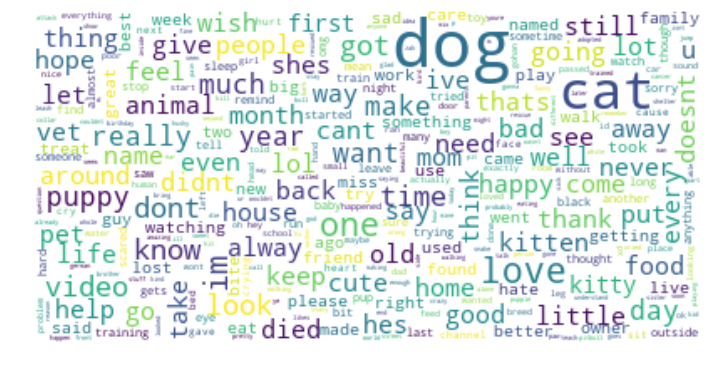

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

cloud = WordCloud(background_color="white", max_words=20000, collocations = False,
                    contour_width=3, contour_color='steelblue',max_font_size=40)

joined1 = " ".join([(k + " ")*v for k,v in words_dic1])

cloud.generate(joined1)

fig1, ax1=plt.subplots(nrows=1,figsize=(12,8))
ax1.imshow(cloud,interpolation='bilinear')

ax1.axis("off")
display(fig1)

#### 4.2 Topics among identified owners

In [0]:
identified_owners_filtered = remover.transform(identified_owners)

list_of_words2 = list(identified_owners_filtered.select('filtered').toPandas()['filtered'])
words2 = [word for arr in list_of_words2 for word in arr] 

words_dic2 = Counter(words2)
words_dic2 = sorted(words_dic2.items(), key=lambda x: x[1], reverse=True)

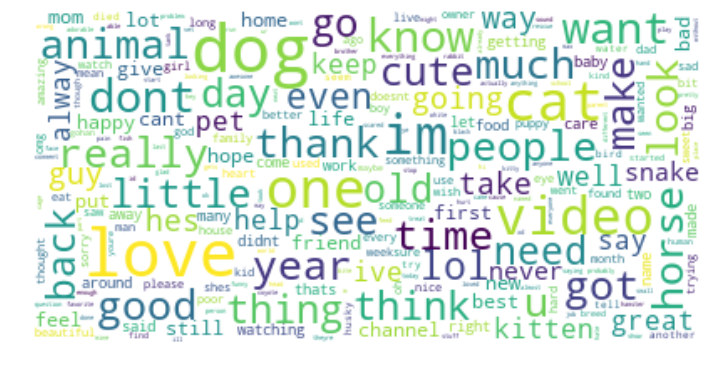

In [0]:
joined2 = " ".join([(k + " ")*v for k,v in words_dic2])

cloud.generate(joined2)

fig2, ax2=plt.subplots(nrows=1,figsize=(12,8))
ax2.imshow(cloud,interpolation='bilinear')

ax2.axis("off")
display(fig2)

#### 4.3 Topics among non owners

In [0]:
predicted_not_owners_filtered = remover.transform(predicted_not_owners)

list_of_words3 = list(predicted_not_owners_filtered.select('filtered').toPandas()['filtered'])
words3 = [word for arr in list_of_words3 for word in arr] 

words_dic3 = Counter(words3)
words_dic3 = sorted(words_dic3.items(), key=lambda x: x[1], reverse=True)

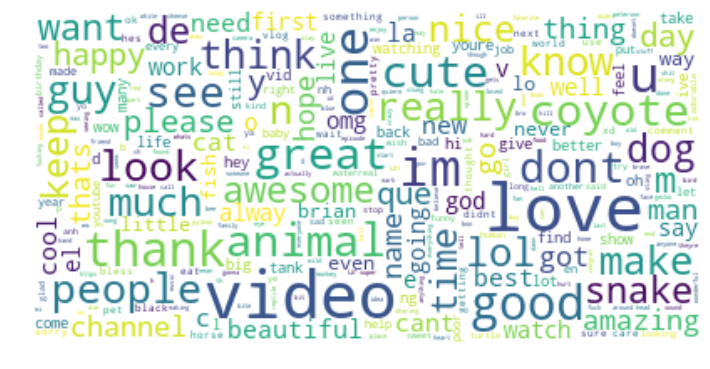

In [0]:
joined3 = " ".join([(k + " ")*v for k,v in words_dic3])

cloud.generate(joined3)

fig3, ax3=plt.subplots(nrows=1,figsize=(12,8))
ax3.imshow(cloud,interpolation='bilinear')

ax3.axis("off")
display(fig3)

### Step 5. Identify Creators With Cat And Dog Owners In The Audience

In [0]:
# find the top 10 creators who have the most comments from cat/dog owners
ownersComments_per_creator = predicted_owners.groupBy('creator_name').count().orderBy('count', ascending=False)
ownersComments_per_creator = ownersComments_per_creator.withColumnRenamed('count', 'comments_count')
display(ownersComments_per_creator.limit(10))

creator_name,comments_count
Brave Wilderness,74571
The Dodo,63075
Taylor Nicole Dean,44357
Brian Barczyk,42515
Robin Seplut,32629
Gohan The Husky,27135
Hope For Paws - Official Rescue Channel,26485
Vet Ranch,21569
Gone to the Snow Dogs,16224
Viktor Larkhill,16039


In [0]:
# find out top 10 creators who have most cat/dog owners comment on their videos
from pyspark.sql.functions import countDistinct
owners_per_creator = predicted_owners.select('creator_name', 'userid').distinct() \
                                     .groupBy('creator_name').count().orderBy('count', ascending=False)
owners_per_creator = owners_per_creator.withColumnRenamed('count', 'owners_count')
display(owners_per_creator.limit(10))

creator_name,owners_count
Brave Wilderness,67980
The Dodo,43789
Taylor Nicole Dean,36415
Brian Barczyk,27368
Hope For Paws - Official Rescue Channel,22996
Gohan The Husky,21884
Vet Ranch,17827
Robin Seplut,16680
Cole & Marmalade,11563
stacyvlogs,10985


In [0]:
# find out creators who have attracted more than 500 users and half of the users are cat/dog owners
joined = owners_per_creator.join(users_per_creator, 'creator_name')
joined = joined.withColumn('percentage', col('owners_count')/col('users_count')).orderBy('percentage', ascending=False)
res = joined.filter(col('users_count')>=500).filter(col('percentage') >= 0.5)
res.show()

+--------------------+------------+-----------+------------------+
 creator_name|owners_count|users_count| percentage|
+--------------------+------------+-----------+------------------+
Zak Georges Dog T...| 8563| 13404|0.6388391524917935|
 Schnauzer Mom| 440| 701|0.6276747503566333|
 Floppycats.com| 351| 560|0.6267857142857143|
 Larry Krohn| 368| 598|0.6153846153846154|
 teardropface| 390| 656|0.5945121951219512|
 Daily Monkey| 458| 796|0.5753768844221105|
 StormyRabbits| 2426| 4285|0.5661610268378063|
 Stonnie Dennis| 272| 501|0.5429141716566867|
 Lennon The Bunny| 3517| 6488|0.5420776818742293|
 Pawfessor| 386| 715|0.5398601398601398|
 wingsNpaws| 548| 1027|0.5335929892891919|
 BrookIvy3| 438| 873|0.5017182130584192|
+--------------------+------------+-----------+------------------+